# Lac Pavin phage analysis

In [1]:
import matplotlib, re, os, glob, datetime, difflib, random, time, math, json, wget
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess as sp
sns.set('notebook')
%matplotlib inline 
# hide warnings
import warnings
warnings.filterwarnings('ignore')
from Bio import SeqIO, SeqUtils, SearchIO

In [2]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        
def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def categorize(sample_name):
    if "SED" in sample_name:
        return "sediment"
    elif "12" in sample_name:
        return "shallow"
    elif "70" in sample_name or "90" in sample_name:
        return "anoxic zone"
    else: return "interface"

In [3]:
rootdir = "/groups/banfield/projects/environmental/LacPavin/analysis/viral/"

# integrate with previous pubs

In [4]:
import skbio.io
cmdir(rootdir + "/genomes/previous")

### gather genomes

In [5]:
# read in hpae supp table
hpae = pd.read_csv(rootdir + "metadata/hpae_table_s1.csv").fillna("None")
hpae_sub = hpae[hpae["Environment of origin"]=="Lac Pavin, France"]
hpae_sub.head()

,Genome name,Length,Complete,Environment of origin,Circularized,Manually curated,rpS21 phylogeny confirms host,Host Spacer Match,CRISPR-Cas,Cas1,Cas2,Effector Complex,Interference,CRISPR System Type,Source Reference,Source Reference Author,Source Reference DOI,Genome Accession,Sample Accession (Reads)
167,LP_PHAGE_COMPLETE_CIR-CU-CL_32_25,735411.0,Y,"Lac Pavin, France",Y,Y,Y,N,N,N,N,None,None,None,Jaffe et al. in prep,Jaffe et al. in prep,None,ERS4026464,ERS4025720
168,LP_PHAGE_COMPLETE_CIR-CU-CL_32_18,735411.0,Y,"Lac Pavin, France",Y,Y,Y,N,N,N,N,None,None,None,Jaffe et al. in prep,Jaffe et al. in prep,None,ERS4026465,ERS4025718
169,LP_PHAGE_COMPLETE_CIR-CU-CL_31_18,642428.0,Y,"Lac Pavin, France",Y,Y,Y,N,N,N,N,None,None,None,Jaffe et al. in prep,Jaffe et al. in prep,None,ERS4026417,ERS4025718
170,LP_PHAGE_38_17,399135.0,None,"Lac Pavin, France",None,None,N,N,N,N,N,None,None,None,Jaffe et al. in prep,Jaffe et al. in prep,None,ERS4026265,ERS4025717
171,LP_PHAGE_39_54,378298.0,None,"Lac Pavin, France",None,None,N,N,N,N,N,None,None,None,Jaffe et al. in prep,Jaffe et al. in prep,None,ERS4026264,ERS4025717


Download from public ggkbase project - NCBI too complicated.

In [6]:
# separate fastas for bs21
for record in SeqIO.parse(open(rootdir + "genomes/previous/LacPavin.curated.fasta"), "fasta"):
    if "ALND" not in record.description:
        with open(rootdir + "genomes/previous/" + record.description.split(" ")[0] + ".fa", "w") as out:
            out.write(">%s\n%s\n" %(record.description.split(" ")[0], str(record.seq)))

### blast

Combine all LP and all previously published in separate, combined files.

In [ ]:
makedb = "makeblastdb -in " + rootdir + "genomes/previous/ALL_LP.fa -dbtype nucl -out " + rootdir + "genomes/previous/ALL_LP"
print(makedb)
blast = "blastn -db %s -query %s -out %s -evalue 1e-3 -max_target_seqs 10 -num_threads 16 -sorthits 3 -outfmt 6\n" %(rootdir + "genomes/previous/ALL_LP", rootdir + "genomes/previous/ALL_PREV.fa", rootdir + "genomes/previous/LP_PREV.results")
print(blast)

In [6]:
# read in prev scaf2bin + scaf lens
prev_dict = {}

for genome in glob.glob(rootdir + "genomes/previous/L*.fa"):
    name = os.path.basename(genome).split(".contigs")[0].split(".fa")[0]
    fasta = [record for record in SeqIO.parse(open(genome), "fasta")][0]
    prev_dict[fasta.description.split(" ")[0]] = {"name": name, "len": len(fasta.seq)}

In [7]:
bresults = skbio.io.read(rootdir + "genomes/previous/LP_PREV.results", format="blast+6", into=pd.DataFrame, default_columns=True)
# correspond prev and current
mapping = bresults[(bresults["pident"]>90) & (bresults["length"]>10000)].sort_values("qseqid").drop_duplicates(["qseqid", "sseqid"])[["qseqid", "sseqid"]]
# select one prev in cases where there is redudancy (by size)
mapping["len"] = mapping["qseqid"].apply(lambda x: prev_dict[x]["len"])
mapping_nr = mapping.sort_values("len", ascending=False).drop_duplicates("sseqid")

### alter metadata

In [8]:
metadata = pd.read_csv(rootdir + "metadata/curated_viral_metadata_subset.tsv", sep="\t")
metadata.head()

,scaffold,sample,source,curated_category,scaffold_length,region_length,putative_euk_virus,primary_cluster,secondary_cluster,representative,circularized
0,LacPavin_0419_WC70S_scaffold_401069,LacPavin_0419_WC70S,both,virus:checkv,51112,51112.0,False,637.0,637_0,True,False
1,LacPavin_0818_WC45_scaffold_91954,LacPavin_0818_WC45,both,virus:checkv,179571,179571.0,False,101.0,101_1,True,True
2,LacPavin_0818_WC40_scaffold_708649,LacPavin_0818_WC40,both,virus:checkv,78802,78802.0,False,401.0,401_0,True,False
3,LacPavin_0419_WC70S_scaffold_345132,LacPavin_0419_WC70S,both,virus:checkv,67427,67427.0,False,632.0,632_0,True,True
4,LacPavin_0818_WC40_scaffold_138018,LacPavin_0818_WC40,virsorter,virus:checkv,149426,149426.0,False,659.0,659_0,True,False


In [9]:
prev_md = defaultdict(list)

for prev in mapping_nr["qseqid"].unique():
    
    prev_md["scaffold"].append(prev)
    prev_md["sample"].append("_".join(prev.split("_")[0:3]))
    
    if "prodigal" in prev:
        prev_md["source"].append("hpae")
    else: prev_md["source"].append("bs21")
    
    prev_md["curated_category"].append("virus:manual")
    prev_md["scaffold_length"].append(prev_dict[prev]["len"])
    prev_md["region_length"].append(prev_dict[prev]["len"])
    prev_md["putative_euk_virus"].append(False)
    
    # steal clustering info from what's being replaced
    sseqids = mapping_nr[mapping_nr["qseqid"]==prev]["sseqid"].to_list()
    # if multiple sseqids, this is usually the same
    prev_md["primary_cluster"].append(metadata[metadata["scaffold"]
        .isin(sseqids)]["primary_cluster"].iloc[0])
    
    # this may not be - if so, just add None
    secondaries = metadata[metadata["scaffold"].isin(sseqids)]["secondary_cluster"].to_list()
    if len(secondaries) == 1:
        prev_md["secondary_cluster"].append(secondaries[0])
    else: prev_md["secondary_cluster"].append("None")
    
    prev_md["representative"].append(True)
    
    #circularized?
    if "prodigal" in prev:
        name = prev_dict[prev]["name"]
        info = hpae_sub[hpae_sub["Genome name"]==name]
        if info["Circularized"].iloc[0] == "Y":
            prev_md["circularized"].append(True)
        else: prev_md["circularized"].append(False)
    
    # for bs21 - circ in scaf name
    elif "circular" in prev:
        prev_md["circularized"].append(True)
    
    else: prev_md["circularized"].append(False)
    
prev_df = pd.DataFrame(prev_md)

In [10]:
# integrate
int_metadata = pd.concat([metadata[~metadata["scaffold"].isin(mapping["sseqid"].to_list())], prev_df])
# add genome column
int_metadata["genome_name"] = int_metadata.apply(lambda x: prev_dict[x["scaffold"]]["name"] if x["source"] 
                                in ['hpae', "bs21"] else x["scaffold"], axis=1)
int_metadata = int_metadata[["genome_name"] + [col for col in int_metadata.columns if col != "genome_name"]]
int_metadata.shape

(797, 12)

In [174]:
int_metadata.to_csv(rootdir + "metadata/curated_viral_metadata_integrated.tsv", sep="\t", index=False)

Use this as a starting point for a supplementary table!

### alter sequences

In [ ]:
cmdir(rootdir + "/genomes/integrated_genomes")

Manually cp all final_genomes and hpae genomes into here.

In [ ]:
# then delete extras
for genome in glob.glob(rootdir + "genomes/integrated_genomes/*"):
    
    name = os.path.basename(genome).split(".")[0]
    if name not in int_metadata["genome_name"].to_list():
        sp.call("rm " + genome, shell=True)

### size comparison

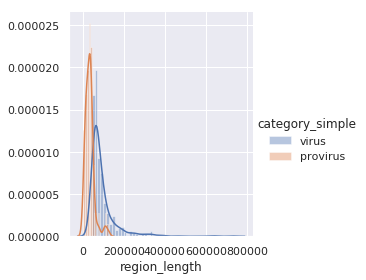

In [11]:
int_metadata["category_simple"] = int_metadata["curated_category"].apply(lambda x: x.split(":")[0])
g = sns.FacetGrid(int_metadata, hue="category_simple", sharey=False, sharex=False, height=4)
g.map(sns.distplot, "region_length", kde=True)
g.add_legend().set_titles("{col_name}")
plt.show()

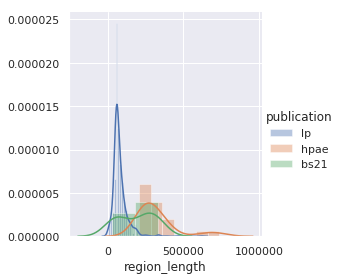

In [12]:
int_metadata["publication"] = int_metadata["source"].apply(lambda x: x if x in ["hpae", "bs21"] else "lp")
g = sns.FacetGrid(int_metadata, hue="publication", sharey=False, sharex=False, height=4)
g.map(sns.distplot, "region_length", kde=True)
g.add_legend().set_titles("{col_name}")
plt.show()

# diversity analyses

### define data sources

In [13]:
# gather read files
reads = {"water_column":[], "sediment":[]}

# project dir
for sample in glob.glob(rootdir.replace("analysis/viral/", "QB3*/raw.d/*/")):
    if (("Creux" not in sample) and ("07_03" not in sample)):
        fwd = glob.glob(sample + "/*.PE.1.fastq.gz")[0]
        rev = glob.glob(sample + "/*.PE.2.fastq.gz")[0]
        reads["water_column"].append((fwd,rev))

# /banfield/sequences
for sample in glob.glob("/groups/banfield/sequences/2020/LacPavin*/"):
    if "ALN" not in sample:
        fwd = glob.glob(sample + "raw.d/*.PE.1.fastq.gz")[0]
        rev = glob.glob(sample + "raw.d/*.PE.2.fastq.gz")[0]
        if "SED" in sample:
            reads["sediment"].append((fwd, rev))
        else: reads["water_column"].append((fwd, rev))

### run remapping

In [ ]:
cmdir(rootdir + "remapping")

In [ ]:
# combine genomes
with open(rootdir + "remapping/all_genomes.fa", "w") as outfile:
    for genome in glob.glob(rootdir + "/genomes/integrated_genomes/*"):
        for record in SeqIO.parse(open(genome), "fasta"):
            outfile.write(">" + record.description.split(" ")[0] + "\n" + str(record.seq) + "\n")

In [ ]:
#build bt index
call = "/shared/software/bin/bowtie2-build " + rootdir + "/remapping/all_genomes.fa " + \
    rootdir + "remapping/all_genomes.fa"
sp.call(call, shell=True)

#remap reads from all samples
for biome in reads:

    for read_tuple in reads[biome]:

        rcode = "R" + "".join(os.path.basename(read_tuple[0]).split("_")[1:3])
        filecode = rootdir + "remapping/genomes_" + rcode

        with open(rootdir + "remapping/" + rcode + ".sh", "w") as out:
            # generate mapping
            mapping = "/shared/software/bin/bowtie2 -p 48 -x " + rootdir + "remapping/all_genomes.fa -1 " + \
                read_tuple[0] + " -2 " + read_tuple[1] + " 2> " + filecode + ".log" + \
                " | /shared/software/bin/shrinksam | /shared/software/bin/samtools view -S -b > " + filecode + ".bam"
            # generate sorted bam + idx
            sort = "/shared/software/bin/samtools sort --threads 45 " + filecode + ".bam > " + filecode + ".sorted.bam"
            index = "/shared/software/bin/samtools index -@ 48 " + filecode + ".sorted.bam"
            out.write(mapping + "\n" + sort + "\n" + index + "\n")  

for item in $(ls /groups/banfield/projects/environmental/LacPavin/analysis/viral/remapping/*sh); do sbatch --wrap "$item"; done

### compute relative coverage

Manually change all prev suffixes to fna.

In [ ]:
coverm = "coverm genome --genome-fasta-directory " + rootdir + "/genomes/integrated_genomes/ -x fna --min-read-percent-identity 0.95" + \
            " --min-covered-fraction 0 --output-format sparse -b " + rootdir + "/remapping/*sorted.bam -m" + \
            " count mean covered_fraction length rpkm > " + rootdir + "/remapping/coverage_table.csv"
print(coverm)

In [14]:
# downselect 95 threshold + remove 70S
covsub = pd.read_csv(rootdir + "/remapping/coverage_table.csv", sep="\t")
covsub = covsub[covsub["Covered Fraction"]>=0.50]
# calculate relative coverage
covsums = covsub.groupby(["Sample"], as_index=False).aggregate({"Mean":"sum"})
covsums.columns = ["Sample", "total_genome_coverage"]
# also remove 70S
covmerge = covsub[~covsub["Sample"].str.contains("70S")].merge(covsums, how="left", on= "Sample")
covmerge["relative_coverage"] = covmerge.apply(lambda x: x["Mean"]/x["total_genome_coverage"], axis=1)
covmerge["perc_relative_coverage"] = covmerge["relative_coverage"].apply(lambda x: 100*x)
covmerge["log_relative_coverage"] = covmerge["relative_coverage"].apply(lambda x: math.log10(x) if x != 0 else 0)
covmerge.sort_values("Covered Fraction").head()

,Sample,Genome,Read Count,Mean,Covered Fraction,Length,RPKM,total_genome_coverage,relative_coverage,perc_relative_coverage,log_relative_coverage
1096,genomes_R0818WC45.sorted,LP_PHAGE_30_11.contigs,1242,0.788547,0.500068,228957,1.983389,3636.258140,0.000217,0.021686,-3.663827
2509,genomes_R0920SED4.sorted,LacPavin_0920_SED5_scaffold_45227,569,0.933996,0.500115,91023,2.647600,3805.976928,0.000245,0.024540,-3.610121
341,genomes_R0419WC90.sorted,LacPavin_0920_WC12_scaffold_86471,686,0.747869,0.500314,128817,25.258660,612.742941,0.001221,0.122053,-2.913453
1371,genomes_R0818WC55.sorted,LacPavin_0818_WC45_scaffold_335749,45,0.615069,0.500377,10622,3.552872,1660.501661,0.000370,0.037041,-3.431316
1487,genomes_R0818WC55.sorted,LacPavin_0818_WC40_scaffold_857436,494,0.784203,0.500638,91713,4.517201,1660.501661,0.000472,0.047227,-3.325811


### heatmap

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.colors import LogNorm
cmdir(rootdir + "figures")

In [17]:
# cluster genomes based on log rel cov
logpiv = covmerge.pivot("Sample", "Genome", "log_relative_coverage").fillna(0)
col_clustering = linkage(logpiv.transpose(), method='average', metric="euclidean")
col_idx = dendrogram(col_clustering, no_plot=True)["ivl"]
cols = [logpiv.columns[int(i)] for i in col_idx]

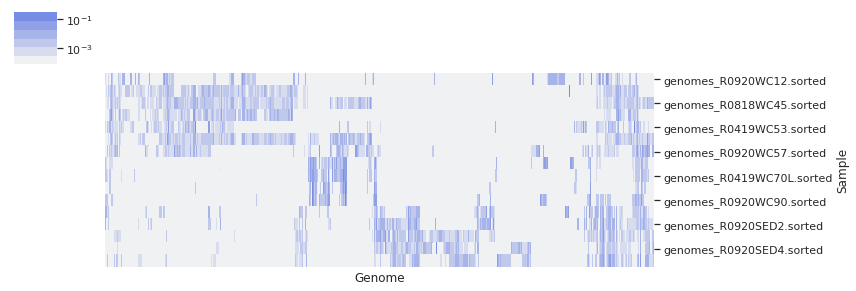

In [21]:
# prep matrix
relpiv = covmerge.pivot("Sample", "Genome", "relative_coverage").reset_index().fillna(covmerge["relative_coverage"].min()*1.01)
relpiv_sorted = relpiv.sort_values(by="Sample", key=lambda col: [x.split(".")[0].split("_R")[1][5:] for x in col])
relpiv_sorted.index = relpiv_sorted["Sample"]
relpiv_sorted = relpiv_sorted.drop("Sample", axis=1)
relpiv_sorted = relpiv_sorted[cols]

# plot
pal = sns.light_palette((260, 75, 60), input="husl")
sns.clustermap(relpiv_sorted,cmap=pal,norm=LogNorm(covmerge["relative_coverage"].min(), covmerge["relative_coverage"].max()), 
    row_cluster=False, col_cluster=False, xticklabels=False, figsize=(12,4), dendrogram_ratio=(0.1,0.2))
#plt.savefig(rootdir + "figures/heatmap_all.svg", format="svg")
plt.show()

# proteins

In [ ]:
cmdir(rootdir + "protein")
cmdir(rootdir + "protein/all")

### run prodigal in all codes

In [ ]:
with open(rootdir + "scripts/predict.sh", "w") as out:
    
    for genome in glob.glob(rootdir + "genomes/integrated_genomes/*.fna"):
        
        region_len = [len(record.seq) for record in SeqIO.parse(open(genome), "fasta")][0]
        protein = rootdir + "protein/all/" + os.path.basename(genome).replace("fna", "faa")
        if region_len >= 20000:
            for code in ["11", "15", "4"]:
                prodigal = "prodigal -p single -m -a %s -d %s -g %s -i %s" %(protein.replace("faa", code + ".faa"), protein.replace("faa", code + ".genes"), code, genome)
                out.write(prodigal + "\n")
        else:
            prodigal = "prodigal -p meta -m -a %s -d %s -i %s -o %s" %(protein.replace("faa", "meta.faa"), protein.replace("faa", "meta.genes"), genome, protein.replace("faa", "meta.gbk"))
            out.write(prodigal + "\n")

In [22]:
# read results back into df
coding_info = defaultdict(list)

for genome in glob.glob(rootdir + "genomes/integrated_genomes/*fna"):
    
    scaflen = [len(record.seq) for record in SeqIO.parse(open(genome), "fasta")][0]
        
    for pred in glob.glob(rootdir + "protein/all/" + os.path.basename(genome).split(".")[0] + "*genes"):

        if "meta" in pred:
            code = open(pred.replace("genes", "gbk")).readlines()[0].split(";")[-2].split("=")[1]
        else: code = os.path.basename(pred).replace(".contigs", "").split(".")[1]
            
        nuclens = [len(record.seq) for record in SeqIO.parse(open(pred), "fasta")]
        protlens = [len(record.seq) for record in SeqIO.parse(open(pred.replace("genes", "faa")), "fasta")]
        
        coding_info["scaf"].append(os.path.basename(genome).replace(".fna", ""))
        coding_info["scaflen"].append(scaflen)
        coding_info["code"].append(code)
        coding_info["median_orf_len"].append(np.median(nuclens))
        coding_info["median_prot_len"].append(np.median(protlens))
        coding_info["coding_density"].append(sum(nuclens)/float(scaflen))
        
coding_df = pd.DataFrame(coding_info)
coding_df.head()

,scaf,scaflen,code,median_orf_len,median_prot_len,coding_density
0,LacPavin_0920_SED4_scaffold_345858,65097,15,562.5,187.5,0.952855
1,LacPavin_0920_SED4_scaffold_345858,65097,11,546.0,182.0,0.954191
2,LacPavin_0920_SED4_scaffold_345858,65097,4,574.5,191.5,0.949399
3,LacPavin_0920_SED4_scaffold_1476276,60490,11,411.0,137.0,0.885617
4,LacPavin_0920_SED4_scaffold_1476276,60490,15,420.0,140.0,0.890230


### analyze

In [23]:
density_info = defaultdict(list)

for scaf in coding_df["scaf"].unique():
    
    subtable = coding_df[coding_df["scaf"]==scaf]
    density_info["scaf"].append(scaf)
    density_info["scaflen"].append(subtable["scaflen"].iloc[0])
    sort = subtable.sort_values("coding_density", ascending=False)
    max_code = sort["code"].iloc[0]
    density_info["max_code"].append(max_code)
    density_info["max_cd"].append(sort["coding_density"].iloc[0])
    
    if (len(subtable) > 1) and (max_code!="11"):
        std = sort.query("code=='11'")["coding_density"].iloc[0]
        alt = sort["coding_density"].iloc[0]
        density_info["delta_cd"].append(alt-std)
    else: density_info["delta_cd"].append("not applicable")

density_df = pd.DataFrame(density_info)

In [24]:
potential_ac = density_df.query("delta_cd!='not applicable'").query("delta_cd>=0.05").sort_values("delta_cd", ascending=False)
potential_ac.to_csv(rootdir + "metadata/potential_ac.tsv", sep="\t", index=False)
potential_ac

,scaf,scaflen,max_code,max_cd,delta_cd
4,LacPavin_0920_SED5_scaffold_1938070,67540,4,0.906796,0.761327
435,LacPavin_0920_SED2_scaffold_93916,91133,4,0.958237,0.188099
28,LP_PHAGE_22_14.contigs,292000,15,0.930205,0.187675
82,LacPavin_0920_WC90_scaffold_877139,20405,15,0.957559,0.087773
526,LacPavin_0920_WC57_scaffold_224181,26767,15,0.955131,0.077446
225,LacPavin_0818_WC40_scaffold_5237,35353,4,0.966453,0.07476
665,LacPavin_0818_WC45_scaffold_120844,21077,4,0.869241,0.073872
199,LacPavin_0920_SED5_scaffold_93206,67834,4,0.854173,0.069567
683,LacPavin_0920_SED3_scaffold_287993,20598,15,0.890038,0.068308
127,LacPavin_0818_WC55_scaffold_501942,36957,15,0.941797,0.059745


### finalize

In [ ]:
cmdir(rootdir + "/protein/final")

In [ ]:
# select correct AA file
for key, row in density_df.iterrows():
    
    # 10% to be conservative - see borges et al 2021
    if (row["max_code"] != "11") and (row["delta_cd"]>=0.10):
        code_choice = row["max_code"]
    else: code_choice = "11"
        
    # find amino acids
    preds = glob.glob(rootdir + "protein/all/" + row["scaf"] + ".*.faa")
    
    if len(preds) == 1:
        aa_path = preds[0]
    else:
        aa_path = rootdir + "protein/all/" + row["scaf"] + \
            "." + code_choice + ".faa"
        
    # write out
    with open(aa_path.replace("all", "final").replace("meta", code_choice), "w") as out:
        for record in SeqIO.parse(open(aa_path), "fasta"):
            out.write(">%s\n%s\n" %(record.description.split(" ")[0], str(record.seq)))

Then head on over to pclust notebook.

# host linkage

In [ ]:
cmdir(rootdir + "host")

In [25]:
ggk_dict = {"Planctomycetota": "Planctomycetes", "Bacteroidota": "Bacteroidetes",
            "Chloroflexota": "Chloroflexi", "Verrucomicrobiota": "Verrucomicrobia",
           "Patescibacteria": "CPR", "Nitrospirota": "Nitrospirae", "Elusimicrobiota": "Elusimicrobia",
            "Armatimonadota": "Armatimonadates", "Actinobacteriota": "Actinobacteria", 
            "Omnitrophota": "OP3X/WOR-2", "Desulfobacterota":"Proteobacteria", 
            "Campylobacterota": "Proteobacteria"}

### crispr-cas

In [53]:
# define samples/assemblies of interest
assemblies = {"water_column":[], "sediment":[]}
for assembly in glob.glob("/groups/banfield/projects/environmental/LacPavin/QB3*/assembly.d/*/*megahit*/*min1000.fa"):
    if ("Creux" not in assembly) and ("ALN" not in assembly):
        if "SED" in assembly:
            assemblies["sediment"].append(assembly)
        else: assemblies["water_column"].append(assembly)

In [ ]:
inputs = defaultdict(list)

for biome in assemblies:
    
    for assembly in assemblies[biome]:
        
        name = os.path.basename(assembly).split("_scaf")[0]
        short = "A" + "".join(name.split("_")[1:])
        bam = glob.glob(rootdir.replace("viral", "binning/mapping/") + short + "_" + \
            short.replace("A", "R") + ".bam")[0]
        
        inputs["sample_name"].append(name)
        inputs["sample_type"].append(biome)
        inputs["assembly_path"].append(assembly)
        inputs["bam_path"].append(bam)
        inputs["protein_path"].append(assembly + ".genes.faa")

inputsdf = pd.DataFrame(inputs)
inputsdf.to_csv(rootdir + "jett/inputs.tsv", sep="\t", index=False)

Using these inputs, run LX script to extract spacers, then concatenate spacers and blast against curated phage set.

In [26]:
# read in all spacers v curated phage blast
pblast = skbio.io.read('/groups/banfield/projects/environmental/LacPavin/analysis/viral/jett/Lin_xing_spacer_to_phage_blast/Blast_Lin_xing_spacers_to_integrated_phage_ALL_results.csv', format="blast+6", 
              into=pd.DataFrame, default_columns=False,  columns=['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 
                'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen'])
pblast["spacer_coverage"] = pblast.apply(lambda x: (abs(x["send"]-x["sstart"]))/x["slen"], axis=1)
pblast["spacer_scaffold"] = pblast["sseqid"].apply(lambda x: x.split("_region")[0])
# adjust scaffold name for prev
prev_to_lp = {row["qseqid"]:row["sseqid"] for key, row in mapping.iterrows()}
pblast["scaffold_adjusted"] = pblast["qseqid"].apply(lambda x: prev_to_lp[x] if x in prev_to_lp.keys() else x)
# filter by quality, also self targeting spacers
pblast_filtered = pblast[(pblast["spacer_coverage"]>=0.90) & (pblast["mismatch"]<=2) & (pblast["scaffold_adjusted"]!=pblast["spacer_scaffold"])]
pblast_filtered.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,slen,spacer_coverage,spacer_scaffold,scaffold_adjusted
4,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_scaffold_95299_region_15954...,100.000,32.0,0.0,0.0,49553.0,49584.0,32.0,1.0,2.010000e-07,52.3,58154.0,32.0,0.968750,LacPavin_0818_WC50_scaffold_95299,LacPavin_0419_WC53_scaffold_304000
5,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_scaffold_95299_region_15954...,96.875,32.0,1.0,0.0,7309.0,7340.0,1.0,32.0,1.810000e-06,49.1,58154.0,32.0,0.968750,LacPavin_0818_WC50_scaffold_95299,LacPavin_0419_WC53_scaffold_304000
6,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_scaffold_95299_region_15954...,96.875,32.0,1.0,0.0,27692.0,27723.0,1.0,32.0,1.810000e-06,49.1,58154.0,32.0,0.968750,LacPavin_0818_WC50_scaffold_95299,LacPavin_0419_WC53_scaffold_304000
7,LacPavin_0419_WC53_scaffold_304000,LacPavin_0419_WC53_scaffold_97078_region_1978_...,100.000,30.0,0.0,0.0,12380.0,12409.0,30.0,1.0,1.810000e-06,49.1,58154.0,30.0,0.966667,LacPavin_0419_WC53_scaffold_97078,LacPavin_0419_WC53_scaffold_304000
8,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_scaffold_95299_region_15954...,96.774,31.0,1.0,0.0,7408.0,7438.0,33.0,3.0,5.430000e-06,47.5,58154.0,33.0,0.909091,LacPavin_0818_WC50_scaffold_95299,LacPavin_0419_WC53_scaffold_304000


In [27]:
### correspond with bins
pblast_merged = pblast_filtered.merge(pd.read_csv(rootdir + "/jett/ggkbase_scaf2bin/ALL.scaffolds_to_bin.tsv", \
    sep="\t")[["scaffold_name", "bin"]], left_on="spacer_scaffold", right_on="scaffold_name", how="left").drop("scaffold_name", axis=1)

# add bin taxonomy 
bin_taxonomy = {}

# non representative/refined
prelim_gt = pd.concat(pd.read_csv(item, sep="\t") for item in \
    glob.glob("/groups/banfield/projects/environmental/LacPavin/analysis/genomes/gtdb-tk/batch*/*.summary.tsv"))
for key, row in prelim_gt.iterrows():
    bin_taxonomy[row["user_genome"].split(".contigs")[0].replace(".", "_").replace("_sub", "")] = row["classification"].split(";")[1].replace("p__","")

# representative/refined
for key, row in pd.read_csv("/groups/banfield/projects/environmental/LacPavin/analysis/tables/jaffe_table_s1.tsv", sep="\t").iterrows():
    phylum = row["ggkbase_taxonomy"].split(",")[-2] if len(row["ggkbase_taxonomy"].split(",")) > 1 else row["ggkbase_taxonomy"].split(",")[-1]
    bin_taxonomy[row["genome_name"]] = row["gtdbtk_taxonomy"].split(";")[1].replace("p__", "")
    #bin_taxonomy[row["genome_name"]] = phylum.strip()
    
# merge in
pblast_merged["bin_clean"] = pblast_merged["bin"].apply(lambda x: x.split("_sub")[0])
pblast_merged["bin_taxonomy"] = pblast_merged["bin_clean"].map(bin_taxonomy).fillna("None")

In [31]:
# when no bin, try to read in ggkbase contig level taxonomy
contig_taxonomy = {}

for file in glob.glob(rootdir + "jett/ggkbase_contig_taxonomy/Lac*.tsv"):
    for key, row in pd.read_csv(file, sep="\t").iterrows():
        # only use more confident taxonomy
        if (float(row["Size (bp)"]) > 10000) & (float(row["Phylum winner %"]) > 0.50) & \
            (row["Phylum winner"] != "unknown"):
                contig_taxonomy[row["Contig name"]] = row["Phylum winner"]

In [32]:
pblast_merged["contig_taxonomy"] = pblast_merged.apply(lambda x: contig_taxonomy[x["spacer_scaffold"]] if ("UNK" in x["bin"]) and (x["spacer_scaffold"] in contig_taxonomy.keys()) else "None", axis=1)
pblast_merged.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,...,bitscore,qlen,slen,spacer_coverage,spacer_scaffold,scaffold_adjusted,bin,bin_clean,bin_taxonomy,contig_taxonomy
0,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_scaffold_95299_region_15954...,100.000,32.0,0.0,0.0,49553.0,49584.0,32.0,1.0,...,52.3,58154.0,32.0,0.968750,LacPavin_0818_WC50_scaffold_95299,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_Planctomycetia_59_41,LacPavin_0818_WC50_Planctomycetia_59_41,Planctomycetota,None
1,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_scaffold_95299_region_15954...,96.875,32.0,1.0,0.0,7309.0,7340.0,1.0,32.0,...,49.1,58154.0,32.0,0.968750,LacPavin_0818_WC50_scaffold_95299,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_Planctomycetia_59_41,LacPavin_0818_WC50_Planctomycetia_59_41,Planctomycetota,None
2,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_scaffold_95299_region_15954...,96.875,32.0,1.0,0.0,27692.0,27723.0,1.0,32.0,...,49.1,58154.0,32.0,0.968750,LacPavin_0818_WC50_scaffold_95299,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_Planctomycetia_59_41,LacPavin_0818_WC50_Planctomycetia_59_41,Planctomycetota,None
3,LacPavin_0419_WC53_scaffold_304000,LacPavin_0419_WC53_scaffold_97078_region_1978_...,100.000,30.0,0.0,0.0,12380.0,12409.0,30.0,1.0,...,49.1,58154.0,30.0,0.966667,LacPavin_0419_WC53_scaffold_97078,LacPavin_0419_WC53_scaffold_304000,LacPavin_0419_WC53_UNK,LacPavin_0419_WC53_UNK,None,None
4,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_scaffold_95299_region_15954...,96.774,31.0,1.0,0.0,7408.0,7438.0,33.0,3.0,...,47.5,58154.0,33.0,0.909091,LacPavin_0818_WC50_scaffold_95299,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_Planctomycetia_59_41,LacPavin_0818_WC50_Planctomycetia_59_41,Planctomycetota,None


In [33]:
# finalize
chosts = defaultdict(list)

for key, row in pblast_merged.iterrows():
    
    chosts["scaffold"].append(row["qseqid"])
    
    if "UNK" not in row["bin"]:
        chosts["crispr_host_name"].append(row["bin_clean"])
        chosts["crispr_host_taxonomy_raw"].append(row["bin_taxonomy"])
        chosts["crispr_host_type"].append("binned crispr array")
    
    else:
        chosts["crispr_host_name"].append("None")
        chosts["crispr_host_taxonomy_raw"].append(row["contig_taxonomy"])
        chosts["crispr_host_type"].append("unbinned crispr array")

chosts_df = pd.DataFrame(chosts).query("crispr_host_taxonomy_raw !='None'").drop_duplicates()
chosts_df["crispr_host_taxonomy"] = chosts_df["crispr_host_taxonomy_raw"].apply(lambda x: ggk_dict[x] if x in ggk_dict else x)
chosts_df.head()

,scaffold,crispr_host_name,crispr_host_taxonomy_raw,crispr_host_type,crispr_host_taxonomy
0,LacPavin_0419_WC53_scaffold_304000,LacPavin_0818_WC50_Planctomycetia_59_41,Planctomycetota,binned crispr array,Planctomycetes
5,LacPavin_0419_WC70S_scaffold_188380,A0920WC90_metabat_152,Verrucomicrobiota,binned crispr array,Verrucomicrobia
8,LacPavin_0419_WC70S_scaffold_188380,A0920WC70_metabat_51,Verrucomicrobiota,binned crispr array,Verrucomicrobia
12,LacPavin_0419_WC70S_scaffold_188380,LacPavin_0419_WC90_Bacteria_56_158,Verrucomicrobiota,binned crispr array,Verrucomicrobia
15,LacPavin_0419_WC70S_scaffold_188380,A0419WC70S_metabat_89,Verrucomicrobiota,binned crispr array,Verrucomicrobia


In [ ]:
## write out specific hits for later use
chosts_df.query("crispr_host_type=='binned crispr array'").to_csv(rootdir + "metadata/crispr_phage_host.tsv", sep="\t", index=False)

### taxonomy

In [36]:
cmdir(rootdir + "host/diamond")
from bs4 import BeautifulSoup

In [ ]:
# split into multiple diamond jobs
with open(rootdir + "scripts/run_diamond.sh", "w") as out:
    
    proteins = [record for record in SeqIO.parse(open(rootdir + "protein/all_phage_proteins.faa"), "fasta")]
    n = round(len(proteins)/9)
    
    for i, cursor in enumerate(range(0, len(proteins),n)):
        # first write out protein file
        with open(rootdir + "host/diamond/block" + str(i) + ".faa", "w") as block:
            for record in proteins[cursor:cursor+n]:
                block.write(">%s\n%s\n" %(record.description, str(record.seq)))
        call = "sbatch -J dmnd" + str(i) + " --wrap 'diamond blastp -d /groups/banfield/users/clarelou/databases/UniRef100/uniref100.translated.dmnd " + \
            "-q %s -o %s --threads 48 -b8 -c1'" %(rootdir + "host/diamond/block" + str(i) + ".faa", rootdir + "host/diamond/matches" + str(i) + ".faa")
        out.write(call + "\n")

In [34]:
# concatenate + collect taxonomy
dmnd = pd.concat(skbio.io.read(item, format="blast+6", into=pd.DataFrame, default_columns=True) for \
            item in glob.glob(rootdir + "host/diamond/matches*"))
# compute coverage
faalens = {record.description.split(" ")[0]: len(record.seq) for record in SeqIO.parse(open(rootdir + "protein/all_phage_proteins.faa"), "fasta")}
dmnd["qlen"] = dmnd["qseqid"].map(faalens)
dmnd["qcov"] = dmnd.apply(lambda x: (x["qend"]-x["qstart"])/x["qlen"], axis=1)
# choose best hits for each
dmnd = dmnd.sort_values(["bitscore", "qcov"], ascending=[False,False]).drop_duplicates("qseqid")
# filter for min cov /eval
dmnd = dmnd[(dmnd["evalue"]<1e-6) & (dmnd["qcov"]>0.70)]
dmnd.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,qcov
16056,LacPavin_0818_WC40_scaffold_1080633_66,A0A222YXC4_2023996_2023996,52.9,4098.0,1817.0,42.0,1.0,4018.0,1.0,4065.0,0.0,4061.0,4020,0.999254
72919,LacPavin_0818_WC55_scaffold_623882_55,A0A2D6P719_2026803_2026803,54.5,4057.0,1713.0,55.0,1.0,3982.0,1.0,3998.0,0.0,3977.0,3983,0.999498
65322,LacPavin_0818_WC45_scaffold_257799_73,A0A222YXC4_2023996_2023996,52.1,3931.0,1777.0,42.0,8.0,3852.0,153.0,4065.0,0.0,3813.0,3855,0.997147
47593,LacPavin_0920_SED3_scaffold_175246_11,A0A222YXC4_2023996_2023996,49.7,4208.0,1829.0,50.0,1.0,4063.0,1.0,4065.0,0.0,3757.0,4066,0.999016
72912,LacPavin_0818_WC40_scaffold_348094_31,A0A3S5JUF3_1986724_1986724,49.1,4217.0,1832.0,43.0,1.0,4172.0,1.0,3948.0,0.0,3751.0,4175,0.999042


In [ ]:
with open(rootdir + "/scripts/uniref_search.sh", "w") as out:
    
    accs = []
    for item in dmnd["sseqid"].unique():
        if item.split("_")[-2] != "None":
            accs.append(item.split("_")[-2])
        else: accs.append(item.split("_")[-1])
    accs_unique = [item for item in set(accs) if item != "N/A"]
    
    # call maxes out at 1000, so adjust parts accordingly
    n = math.ceil(len(accs_unique)/10)
    for i in range(0, len(accs_unique),n):
        out.write("efetch -db taxonomy -mode xml -id %s > %s\n" %(",".join(accs_unique[i:i + n]), \
            rootdir + "/host/diamond/uniref_results_" + str(int(i/n)) + ".xml"))

In [37]:
lineage_info = defaultdict(list)

for xml in glob.glob(rootdir + "host/diamond/*xml"):
    
    for block in BeautifulSoup(open(xml), "xml").findAll('Taxon'):
            
        lineage, phylum = "None", "None"

        if block.find("Lineage"):
            lineage = block.find("Lineage").string

        for level in block.findAll("Taxon"):
            if level.find("Rank").string=="phylum":
                phylum = level.find("ScientificName").string

        lineage_info["taxid"].append(block.find("TaxId").string)
        lineage_info["lineage"].append(lineage)
        lineage_info["phylum"].append(phylum)

lineage_df = pd.DataFrame(lineage_info).query("lineage!='None'")
lineage_df.head()

,taxid,lineage,phylum
0,1705388,cellular organisms; Bacteria; Terrabacteria gr...,Cyanobacteria
11,2479858,cellular organisms; Bacteria; FCB group; Bacte...,Bacteroidetes
21,449393,unclassified entries; unclassified sequences; ...,None
26,1973975,cellular organisms; Bacteria; Proteobacteria; ...,Proteobacteria
33,1349818,cellular organisms; Bacteria; Proteobacteria; ...,Proteobacteria


In [38]:
# add in
dmnd["taxid"] = dmnd["sseqid"].apply(lambda x: x.split("_")[-2] if x.split("_")[-2] != 'None' else x.split("_")[-1])
dmnd["scaffold"] = dmnd["qseqid"].apply(scaffold)
dmnd = dmnd.merge(lineage_df, how="left", on="taxid").fillna("None")
dmnd.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,qcov,taxid,scaffold,lineage,phylum
0,LacPavin_0818_WC40_scaffold_1080633_66,A0A222YXC4_2023996_2023996,52.9,4098.0,1817.0,42.0,1.0,4018.0,1.0,4065.0,0.0,4061.0,4020,0.999254,2023996,LacPavin_0818_WC40_scaffold_1080633,Viruses; Duplodnaviria; Heunggongvirae; Urovir...,Uroviricota
1,LacPavin_0818_WC55_scaffold_623882_55,A0A2D6P719_2026803_2026803,54.5,4057.0,1713.0,55.0,1.0,3982.0,1.0,3998.0,0.0,3977.0,3983,0.999498,2026803,LacPavin_0818_WC55_scaffold_623882,cellular organisms; Archaea; DPANN group; Cand...,Candidatus Woesearchaeota
2,LacPavin_0818_WC45_scaffold_257799_73,A0A222YXC4_2023996_2023996,52.1,3931.0,1777.0,42.0,8.0,3852.0,153.0,4065.0,0.0,3813.0,3855,0.997147,2023996,LacPavin_0818_WC45_scaffold_257799,Viruses; Duplodnaviria; Heunggongvirae; Urovir...,Uroviricota
3,LacPavin_0920_SED3_scaffold_175246_11,A0A222YXC4_2023996_2023996,49.7,4208.0,1829.0,50.0,1.0,4063.0,1.0,4065.0,0.0,3757.0,4066,0.999016,2023996,LacPavin_0920_SED3_scaffold_175246,Viruses; Duplodnaviria; Heunggongvirae; Urovir...,Uroviricota
4,LacPavin_0818_WC40_scaffold_348094_31,A0A3S5JUF3_1986724_1986724,49.1,4217.0,1832.0,43.0,1.0,4172.0,1.0,3948.0,0.0,3751.0,4175,0.999042,1986724,LacPavin_0818_WC40_scaffold_348094,cellular organisms; Bacteria; FCB group; Bacte...,Bacteroidetes


In [39]:
orf_counts = {}

for proteome in glob.glob(rootdir + "protein/final/*"):
    proteins = [record for record in SeqIO.parse(open(proteome), "fasta")]
    orf_counts[scaffold(proteins[0].description)] = len(proteins)

In [40]:
host_info = defaultdict(list)
prok_phyla = lineage_df[lineage_df["lineage"].str.contains("Bacteria") | \
                lineage_df["lineage"].str.contains("Archaea")]["phylum"].unique()

for scaf in dmnd["scaffold"].unique():
    
    subtable = dmnd[dmnd["scaffold"]==scaf].groupby(["scaffold", "phylum"], \
        as_index=False).aggregate({"qseqid":"count"}).sort_values("qseqid", ascending=False)
    # filter down to only prok - no virus, euk
    subtable = subtable[subtable["phylum"].isin(prok_phyla) & (subtable["phylum"]!='None')]
        
    host_info["scaffold"].append(scaf)
    host_info["winner"].append(subtable["phylum"].iloc[0])
    host_info["winner_perc"].append((subtable["qseqid"].iloc[0]/orf_counts[scaf])*100)

    if len(subtable) >1:
        host_info["runnerup"].append(subtable["phylum"].iloc[1])
        host_info["runnerup_perc"].append((subtable["qseqid"].iloc[1]/orf_counts[scaf])*100)
    else:
        host_info["runnerup"].append("None")
        host_info["runnerup_perc"].append(0)

hdf = pd.DataFrame(host_info)

In [41]:
hdf_clean = hdf[(hdf["winner_perc"]>=10) & (hdf["winner_perc"]>(3*hdf["runnerup_perc"]))]
hdf_clean["winner"].value_counts()

Proteobacteria                 150
Bacteroidetes                   97
Spirochaetes                    16
Actinobacteria                  10
Planctomycetes                   7
Verrucomicrobia                  5
Firmicutes                       5
Cyanobacteria                    4
Synergistetes                    2
Euryarchaeota                    2
Candidatus Thorarchaeota         1
Elusimicrobia                    1
Candidatus Thermoplasmatota      1
Name: winner, dtype: int64

### integrate

In [42]:
intsub = int_metadata[["genome_name", "scaffold", "publication", "curated_category", "scaffold_length", "region_length", "circularized"]]
# add crispr + taxonomy
intsub = intsub.merge(chosts_df[["scaffold", "crispr_host_taxonomy"]].drop_duplicates(), on="scaffold", how="left").fillna("None").merge(hdf_clean[["scaffold", "winner"]], how="left", on="scaffold").fillna("None")
intsub.head()

,genome_name,scaffold,publication,curated_category,scaffold_length,region_length,circularized,crispr_host_taxonomy,winner
0,LacPavin_0419_WC70S_scaffold_401069,LacPavin_0419_WC70S_scaffold_401069,lp,virus:checkv,51112,51112.0,False,None,None
1,LacPavin_0818_WC45_scaffold_91954,LacPavin_0818_WC45_scaffold_91954,lp,virus:checkv,179571,179571.0,True,None,Proteobacteria
2,LacPavin_0818_WC40_scaffold_708649,LacPavin_0818_WC40_scaffold_708649,lp,virus:checkv,78802,78802.0,False,None,Bacteroidetes
3,LacPavin_0419_WC70S_scaffold_345132,LacPavin_0419_WC70S_scaffold_345132,lp,virus:checkv,67427,67427.0,True,None,None
4,LacPavin_0818_WC40_scaffold_138018,LacPavin_0818_WC40_scaffold_138018,lp,virus:checkv,149426,149426.0,False,None,Proteobacteria


In [43]:
# add prophage
prosub = intsub[intsub["curated_category"].str.contains("provirus")]
prosub = prosub.merge(pd.read_csv(rootdir + "/jett/ggkbase_scaf2bin/ALL.scaffolds_to_bin.tsv", \
    sep="\t")[["scaffold_name", "bin"]], left_on="scaffold", right_on="scaffold_name", how="left").drop("scaffold_name", axis=1)

def assign_prophage_tax(row):
    
    if "UNK" not in row["bin"]:
        raw = bin_taxonomy[row["bin"].replace("_sub", "")]
        return ggk_dict[raw] if raw in ggk_dict.keys() else raw
    elif row["scaffold"] in contig_taxonomy.keys():
        return contig_taxonomy[row["scaffold"]]
    else: return "None"
    
prosub["prophage_host_taxonomy"] = prosub.apply(lambda x: assign_prophage_tax(x), axis=1)

In [44]:
intsub = intsub.merge(prosub[["scaffold", "prophage_host_taxonomy"]], how="left").fillna("None")
intsub = intsub.rename(columns={"winner": "gene_host_taxonomy"})
intsub.head()

,genome_name,scaffold,publication,curated_category,scaffold_length,region_length,circularized,crispr_host_taxonomy,gene_host_taxonomy,prophage_host_taxonomy
0,LacPavin_0419_WC70S_scaffold_401069,LacPavin_0419_WC70S_scaffold_401069,lp,virus:checkv,51112,51112.0,False,None,None,None
1,LacPavin_0818_WC45_scaffold_91954,LacPavin_0818_WC45_scaffold_91954,lp,virus:checkv,179571,179571.0,True,None,Proteobacteria,None
2,LacPavin_0818_WC40_scaffold_708649,LacPavin_0818_WC40_scaffold_708649,lp,virus:checkv,78802,78802.0,False,None,Bacteroidetes,None
3,LacPavin_0419_WC70S_scaffold_345132,LacPavin_0419_WC70S_scaffold_345132,lp,virus:checkv,67427,67427.0,True,None,None,None
4,LacPavin_0818_WC40_scaffold_138018,LacPavin_0818_WC40_scaffold_138018,lp,virus:checkv,149426,149426.0,False,None,Proteobacteria,None


In [45]:
# reconcile conflicting
def choose_host(row):
    
    cols = [col for col in intsub.columns if "taxonomy" in col]
    hosts = [row[field] for field in cols if row[field] !="None"]
    
    if len(set(hosts)) == 1:
        return hosts[0]
    elif row["crispr_host_taxonomy"] != 'None':
        return row["crispr_host_taxonomy"]
    else: return row["prophage_host_taxonomy"]

intsub["consensus_host_taxonomy"] = intsub.apply(choose_host, axis=1)
intsub["consensus_host_taxonomy"].value_counts()

None                           476
Proteobacteria                 147
Bacteroidetes                  102
Spirochaetes                    16
Planctomycetes                  12
Actinobacteria                  10
Verrucomicrobia                  6
Firmicutes                       5
Cyanobacteria                    4
CPR                              4
Chloroflexi                      3
Elusimicrobia                    3
Synergistetes                    2
Euryarchaeota                    2
Nitrospirae                      1
Armatimonadates                  1
Candidatus Thermoplasmatota      1
OP3X/WOR-2                       1
Candidatus Thorarchaeota         1
Name: consensus_host_taxonomy, dtype: int64

# metabolism

In [ ]:
cmdir(rootdir + "protein/metabolism")

### kegg

In [ ]:
# launch kofamscan
kocall = "sbatch -J kfscan --wrap '/shared/software/bin/exec_annotation -o " + rootdir + "protein/metabolism/vkofamscan.latest.txt " + \
    rootdir + "protein/all_phage_proteins.faa -p /shared/db/kegg/kofam/latest/profiles/prokaryote.hal " + \
    "-k /shared/db/kegg/kofam/latest/metadata/ko_list --cpu $SLURM_CPUS_ON_NODE -f detail'"
print(kocall)

In [65]:
def parse_kofamscan(path):
   
    buffer = []
    for line in open(path).readlines():
        if "#" not in line:
            # hilariously long regex
            m = re.search("[* ]*([\S]+)\s+([\S]+)\s+([0-9.-]+)\s+" + \
                "([0-9.-]+)\s+([0-9.+-e]+)\s(.+?$)", line.strip())
            try:
                buffer.append(m.groups())
            except:
                print(line)

    kodf = pd.DataFrame.from_records(buffer, columns =["gene", "ko", "threshold", "score", "eval", "def"]) 
    buffer=[]
    return kodf

In [66]:
# filter for significance
kodf = parse_kofamscan(rootdir + "protein/metabolism/vkofamscan.latest.txt")
kodf["eval"] = kodf["eval"].apply(lambda x: float(x))
kodf["score"] = kodf["score"].apply(lambda x: float(x))
kodf = kodf[kodf["eval"] < 1e-6]
# get best hit per gene based on score
kfilt = kodf.sort_values('score', ascending=False).drop_duplicates("gene")
kfilt.head()

,gene,ko,threshold,score,eval,def
26486,LacPavin_0818_WC40_scaffold_1029807_39,K02337,915.60,1335.2,0.0,DNA polymerase III subunit alpha [EC:2.7.7.7]
89160,LacPavin_0818_WC55_scaffold_5942_19,K02337,915.60,1293.4,0.0,DNA polymerase III subunit alpha [EC:2.7.7.7]
179423,LacPavin_0920_WC57_scaffold_276981_48,K02337,915.60,1283.3,0.0,DNA polymerase III subunit alpha [EC:2.7.7.7]
41353,LacPavin_0818_WC40_scaffold_244163_123,K02337,915.60,1222.2,0.0,DNA polymerase III subunit alpha [EC:2.7.7.7]
129940,LacPavin_0920_SED4_scaffold_375524_116,K02337,915.60,1139.2,0.0,DNA polymerase III subunit alpha [EC:2.7.7.7]


### phylogenies

In [ ]:
kprok = parse_kofamscan("/groups/banfield/projects/environmental/LacPavin/analysis/pclust/other/kofamscan.latest.txt")
kprok["eval"] = kprok["eval"].apply(lambda x: float(x))
kprok["score"] = kprok["score"].apply(lambda x: float(x))
kprok = kprok[kprok["eval"] < 1e-6]
# get best hit per gene based on score
kpfilt = kprok.sort_values('score', ascending=False).drop_duplicates("gene")
kpfilt.head()

In [ ]:
vseq_dict = {record.description.split(" ")[0]: str(record.seq)
                 for record in SeqIO.parse(open(rootdir + "protein/all_phage_proteins.faa"), "fasta")}
pseq_dict = {record.description.split(" ")[0]: str(record.seq)
                 for record in SeqIO.parse(open("/groups/banfield/projects/environmental/LacPavin/analysis/metabolism/all_genomes.faa"), "fasta")}

with open(rootdir + "protein/metabolism/wrapper.sh", "w") as out:
    
    for orthology in ["K10946", "K01601", "K02703"]:
        
        with open(rootdir + "protein/metabolism/" + orthology + ".faa", "w") as faa:
        
            # gather phage sequences
            vgenes = kfilt[kfilt["ko"]==orthology]["gene"].to_list()
            for vgene in vgenes:
                faa.write(">%s\n%s\n" %(vgene, vseq_dict[vgene]))
            
            # gather prok sequences
            pgenes = kpfilt[kpfilt["ko"]==orthology]["gene"].to_list()
            for pgene in pgenes:
                faa.write(">%s\n%s\n" %(pgene, pseq_dict[pgene]))
            
            # gather references
            if orthology == "K01601":
                name = "rubisco"
            elif orthology == "K10946":
                name = "pmoc"
            else: name = "psba"
            
            ref = glob.glob(rootdir + "protein/metabolism/reference/" + name + "*.references.faa")[0]
            for record in SeqIO.parse(open(ref), "fasta"):
                # reformat references
                clean_name = record.description.split(" # ")[0].replace(" ", "_")
                faa.write(">%s\n%s\n" %(clean_name, str(record.seq)))
            
        # combine + process
        faa_path = rootdir + "protein/metabolism/" + orthology + ".faa"
        out.write("usearch --cluster_fast %s -id 1 -centroids %s\n" %(faa_path, faa_path.replace("faa", "centroids.faa")))
        out.write("mafft --reorder --auto --thread 16 %s > %s\n" %(faa_path.replace("faa", "centroids.faa"), faa_path.replace("faa", "mafft")))
        out.write("trimal -gt 0.1 -in %s -out %s\n" %(faa_path.replace("faa", "mafft"), faa_path.replace("faa", "trimal.mafft")))
        out.write("iqtree -s %s -m TEST -st AA -bb 1000 -nt AUTO -ntmax 16 -pre %s\n" %(faa_path.replace("faa", "trimal.mafft"), orthology))
    
vseq_dict, pseq_dict, kpfilt = [], [], []

# figure time

In [46]:
# define phages to include
inset_metadata = intsub.query("region_length>=100000")
inset_phages = [name + ".contigs" if "LP" in name else name for name in inset_metadata["genome_name"].to_list()]
inset_columns = [col for col in cols if col in inset_phages]
# remove those from inset not included in relpiv - 70S only
inset_trimmed = [col.replace(".contigs", "") for col in inset_columns]

In [47]:
inset_metadata.sort_values("region_length", ascending=False).head()

,genome_name,scaffold,publication,curated_category,scaffold_length,region_length,circularized,crispr_host_taxonomy,gene_host_taxonomy,prophage_host_taxonomy,consensus_host_taxonomy
767,LP_PHAGE_COMPLETE_CIR-CU-CL_32_18,LacPavin_0818_WC45_scaffold_4_curated_closed_c...,hpae,virus:manual,735411,735411.0,True,None,Bacteroidetes,None,Bacteroidetes
768,LP_PHAGE_COMPLETE_CIR-CU-CL_31_18,LacPavin_0818_WC45_scaffold_160996_curated_clo...,hpae,virus:manual,642428,642428.0,True,None,Bacteroidetes,None,Bacteroidetes
432,LacPavin_0920_SED4_scaffold_932881,LacPavin_0920_SED4_scaffold_932881,lp,virus:checkv,623013,623013.0,False,None,None,None,None
713,LacPavin_0920_SED2_scaffold_254720,LacPavin_0920_SED2_scaffold_254720,lp,virus:manual,463180,463180.0,False,None,None,None,None
769,LP_PHAGE_38_17,LacPavin_0818_WC40_scaffold_238879_prodigal-si...,hpae,virus:manual,399135,399135.0,False,None,Spirochaetes,None,Spirochaetes


### top

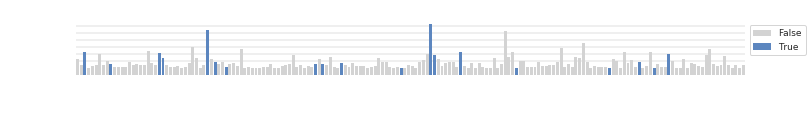

In [48]:
hist_data = inset_metadata[inset_metadata["genome_name"].isin(inset_trimmed)]
hist_data["position"] = hist_data["genome_name"].apply(lambda x: [item.replace(".contigs","") for item in relpiv[inset_columns].columns].index(x))

plt.figure(figsize=(12,1))
sns.set_style("ticks")
sns.barplot(x="position", y="region_length", hue="circularized",
            palette={False:"lightgrey", True:"#4c83cf"}, data=hist_data, dodge=False, linewidth = 0)
for i in range(2,8):
    plt.axhline(i*1e5, c="grey", zorder=0,linewidth=0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)
plt.axis("off")
plt.savefig(rootdir + "figures/size_ticker.svg", format="svg")
plt.show()

### middle

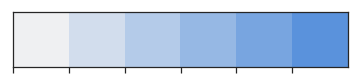

In [49]:
new_pal = sns.light_palette((250, 70, 60), input="husl")
sns.palplot(new_pal)

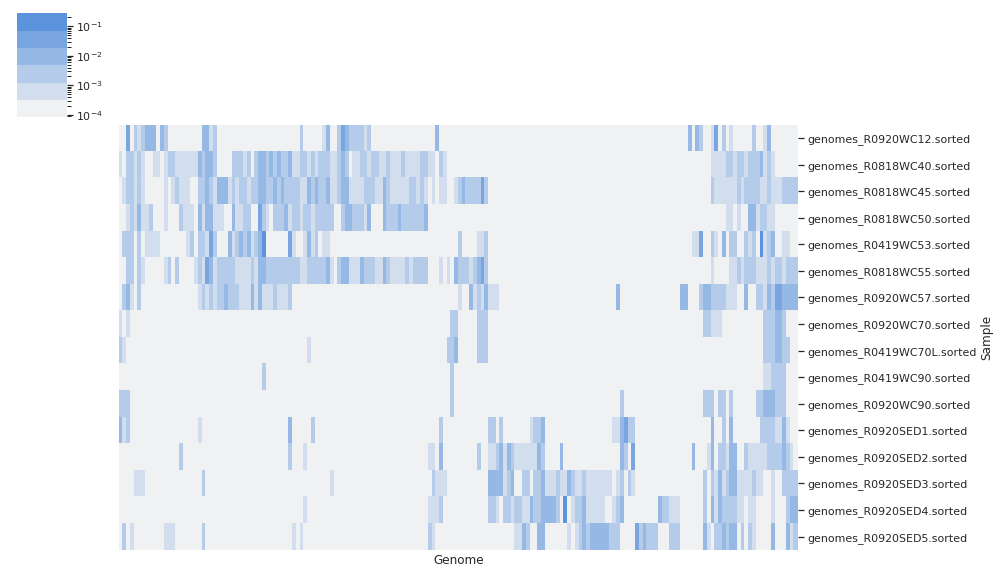

In [51]:
g = sns.clustermap(relpiv_sorted[inset_columns],cmap=new_pal,norm=LogNorm(covmerge["relative_coverage"].min(), covmerge["relative_coverage"].max()), 
    row_cluster=False, col_cluster=False, xticklabels=False, figsize=(14,8), dendrogram_ratio=(0.1,0.2))
plt.savefig(rootdir + "figures/phage_heatmap.svg", format="svg")
plt.show()

### bottom

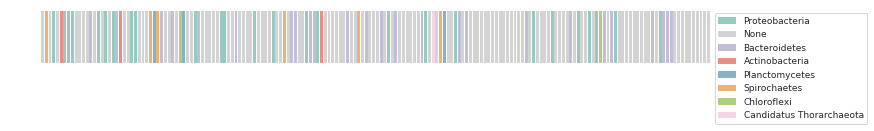

In [52]:
plt.figure(figsize=(12,1))
sns.set_style("ticks")
hist_data["dummy"] = 1

hostpal = {}
for i, val in enumerate(hist_data["consensus_host_taxonomy"].unique()):
    if val != "None":
        hostpal[val] = sns.color_palette("Set3").as_hex()[i]
    else: hostpal[val] = "lightgrey"
    
sns.barplot(x="position", y="dummy", hue="consensus_host_taxonomy",
            palette=hostpal, data=hist_data, dodge=False, linewidth = 0)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)
plt.axis("off")
plt.savefig(rootdir + "figures/host_ticker.svg", format="svg")
plt.show()

# vcontact prep

In [22]:
cmdir(rootdir + "vcontact")
cmdir(rootdir + "vcontact/input_data")

### initiate files

In [311]:
cfaa = open(rootdir + "vcontact/input_data/combined_proteins.faa", "w")
gene2bin = open(rootdir + "vcontact/input_data/gene2bin.tsv", "w")
bin2attr = open(rootdir + "vcontact/input_data/bin2attr.tsv", "w")

### data sources

In [312]:
# hpae
for phage in glob.glob(rootdir + "vcontact/input_data/hpae/*"):
   
    if "PLASMID" not in phage:
        
        name = os.path.basename(phage).split(".")[0]
        
        if "LP_" in name:
            bin2attr.write("%s\t%s\n" %(name, "lac_pavin"))
        else: bin2attr.write("%s\t%s\n" %(name, "hpae"))
        
        try:
            for record in SeqIO.parse(open(phage), "genbank"):
                for feature in record.features:
                    if feature.type == "gene":
                        gene = feature.qualifiers["locus_tag"][0]
                    elif feature.type == "CDS":
                        cfaa.write(">%s\n%s\n" %(gene, feature.qualifiers["translation"][0]))
                        gene2bin.write("%s\t%s\n" %(gene, name))
        except: continue

In [313]:
# biwa and associated references
with open(rootdir + "vcontact/input_data/lake_biwa/biwa_50kb.fna", "w") as out:
    for seqfile in glob.glob(rootdir + "vcontact/input_data/lake_biwa/*[VGC].fna"):
        for record in SeqIO.parse(open(seqfile), "fasta"):
            if len(record.seq) >= 50000:
                out.write(">%s\n%s\n" %(record.description.split(" ")[0], str(record.seq)))
                if "EVG" in seqfile:
                    bin2attr.write("%s\t%s\n" %(record.description.split(" ")[0], "evg"))
                else: bin2attr.write("%s\t%s\n" %(record.description.split(" ")[0], "lake_biwa"))
                
call = "prodigal -a %s -i %s -m -p meta" %(rootdir + "vcontact/input_data/lake_biwa/biwa_50kb.faa", rootdir + "vcontact/input_data/lake_biwa/biwa_50kb.fna")
print(call)

prodigal -a /groups/banfield/projects/environmental/LacPavin/analysis/viral/vcontact/input_data/lake_biwa/biwa_50kb.faa -i /groups/banfield/projects/environmental/LacPavin/analysis/viral/vcontact/input_data/lake_biwa/biwa_50kb.fna -m -p meta


In [314]:
for protein in SeqIO.parse(open(rootdir + "vcontact/input_data/lake_biwa/biwa_50kb.faa"), "fasta"):
    cfaa.write(">%s\n%s\n" %(protein.description.split(" ")[0], str(protein.seq)))
    desc = protein.description.split(" ")[0]
    gene2bin.write("%s\t%s\n" %(desc, "_".join(desc.split("_")[:-1])))

In [315]:
#pmoC phages
cmdir(rootdir + "vcontact/input_data/pmoc")

for record in SeqIO.parse(open(rootdir + "vcontact/input_data/pmoC-phages.final.fasta"), "fasta"):
    
    file = rootdir + "vcontact/input_data/pmoc/" + record.description + ".fna"
    with open(file, "w") as out:
        out.write(">%s\n%s\n" %(record.description, str(record.seq)))
    bin2attr.write("%s\t%s\n" %(record.description, "pmoC"))
    
    call = "prodigal -a %s -i %s -m -p single" %(file.replace(".fna", ".faa"), file)
    sp.call(call, shell=True)
    
    for protein in SeqIO.parse(open(file.replace(".fna", ".faa")), "fasta"):
        cfaa.write(">%s\n%s\n" %(protein.description.split(" ")[0], str(protein.seq)))
        desc = protein.description.split(" ")[0]
        gene2bin.write("%s\t%s\n" %(desc, "_".join(desc.split("_")[:-1])))

In [316]:
# LP
for key, row in int_metadata.query("region_length>=50000").iterrows():
    
    if "LacPavin" in row["genome_name"]:
        
        bin2attr.write("%s\t%s\n" %(row["genome_name"], "lac_pavin"))
        gpath = glob.glob(rootdir + "protein/final/" + row["genome_name"] + "*faa")[0]
        for protein in SeqIO.parse(open(gpath), "fasta"):
            cfaa.write(">%s\n%s\n" %(protein.description.split(" ")[0], str(protein.seq)))
            desc = protein.description.split(" ")[0]
            gene2bin.write("%s\t%s\n" %(desc, "_".join(desc.split("_")[:-1])))

In [317]:
cfaa.close()
gene2bin.close()
bin2attr.close()

### analyze

In [330]:
def classify_cluster(members):
    
    total = len(members)
    
    lp = 0
    for member in members:
        if ("LacPavin" in member) or ("LP_PHAGE" in member):
            lp +=1

    if lp == total:
        return "only_pavin"
    elif lp != 0:
        return "mixed"
    else: return "only_refs"

In [429]:
### things that did cluster
raw_clusters = pd.read_csv(rootdir + "vcontact/Jett_output/viral_cluster_overview.csv")

### things that didn't
genomes = pd.read_csv(rootdir + "vcontact/Jett_output/genome_by_genome_overview.csv").fillna("None")

dummy_info = defaultdict(list)

count=0
for key, row in genomes.iterrows():
    if (("LacPavin" in row["Genome"]) | ("LP_PHAGE" in row["Genome"])) and (row["VC"]=='None'):
        dummy_info["VC"].append("dummy" + str(count))
        dummy_info["Size"].append(1)
        dummy_info["Members"].append(row["Genome"])
        dummy_info["Avg Dist"].append(0)
        for col in raw_clusters.columns:
            if col not in ["VC", "Size", "Members", "Avg Dist"]:
                dummy_info[col].append("None")
        count+=1

merged_clusters = pd.concat([raw_clusters, pd.DataFrame(dummy_info)])
merged_clusters["cluster_category"] = merged_clusters["Members"].apply(lambda x: classify_cluster(x.split(",")))
merged_clusters.head()

,Unnamed: 0,VC,Size,Internal Weight,External Weight,Quality,P-value,Min Dist,Max Dist,Total Dist,Below Thres,Taxon Prediction Score,Avg Dist,Genera,Families,Orders,Members,cluster_category
0,0,VC_100_0,1,0.0,17.571239,0.0,0.0,0.0,0.0,1,1,1.0,0.000000,1,1,1,LacPavin_0920_SED2_scaffold_1717190,only_pavin
1,1,VC_100_1,1,0.0,19.253594,0.0,0.0,0.0,0.0,1,1,1.0,0.000000,1,1,1,LacPavin_0920_SED2_scaffold_61891,only_pavin
2,2,VC_101_0,2,300.0,174.885061,0.631732,0.055245,2.236068,2.236068,1,1,1.0,2.236068,1,1,1,"Vibrio~phage~SSP002,Vibrio~phage~vB_VpaS_MAR10",only_refs
3,3,VC_102_0,3,900.0,7606.852816,0.105797,0.001802,1.0,3.162278,3,3,1.0,2.387426,1,1,1,"Gordonia~phage~Demosthenes,Gordonia~phage~Katy...",only_refs
4,4,VC_102_1,12,19101.939139,18770.660847,0.504374,0.0,2.236068,7.28011,66,66,1.0,4.322340,2,1,1,"Gordonia~phage~Adgers,Gordonia~phage~Beaver,Go...",only_refs


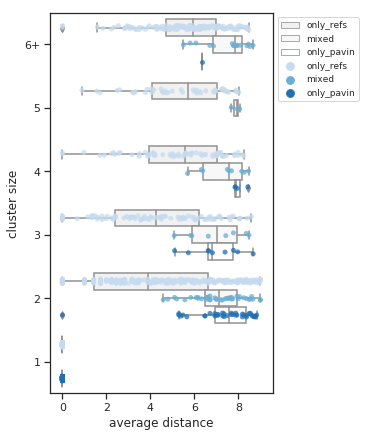

In [431]:
plt.figure(figsize=[4,7])
sns.set_style("ticks")
merged_clusters["size_category"] = merged_clusters["Size"].apply(lambda x: str(x) if x <6 else "6+")
horder = ["only_refs", "mixed", "only_pavin"]
sns.boxplot("Avg Dist", "size_category", data=merged_clusters.sort_values("size_category", ascending=False),
            hue="cluster_category", hue_order=horder, color="white", dodge=True)
sns.stripplot("Avg Dist", "size_category", palette="Blues", data=merged_clusters.sort_values("size_category", ascending=False), 
              hue="cluster_category", color="black", hue_order=horder, alpha=0.75, dodge=True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)
plt.xlabel("average distance")
plt.ylabel("cluster size")
plt.savefig(rootdir + "figures/cluster_size_dist.svg", format="svg")

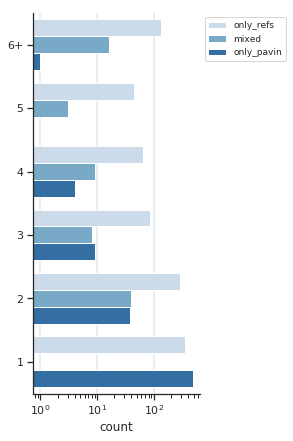

In [432]:
plt.figure(figsize=[3,7])
sns.set_style("ticks")
counts = merged_clusters.groupby(["size_category", "cluster_category"], as_index=False).count()
sns.barplot("VC", "size_category", hue="cluster_category", hue_order=horder, palette="Blues",
            data=counts.sort_values("size_category", ascending=False))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)
for x in [1,10,100]:
    plt.axvline(x, ls="-", linewidth=0.25, zorder=0)
plt.xscale("log")
sns.despine()
plt.xlabel("count")
plt.ylabel("")
plt.savefig(rootdir + "figures/cluster_counts.svg", format="svg")

# supp tables

In [403]:
cmdir(rootdir + "tables/")

In [393]:
cluster_info = defaultdict(list)

for key, row in merged_clusters.iterrows():
    for phage in row["Members"].split(","):
        cluster_info["genome_name"].append(phage)
        cluster_info["vcontact_cluster_members"].append(row["Members"])
        cluster_info["vcontact_cluster_category"].append(row["cluster_category"])
        cluster_info["vcontact_cluster_size"].append(row["Size"])
        cluster_info["vcontact_cluster_avg_dist"].append(row["Avg Dist"])

cluster_info_df = pd.DataFrame(cluster_info)
cluster_info_df.head()

,genome_name,vcontact_cluster_members,vcontact_cluster_category,vcontact_cluster_size,vcontact_cluster_avg_dist
0,LacPavin_0920_SED2_scaffold_1717190,LacPavin_0920_SED2_scaffold_1717190,only_pavin,1,0.000000
1,LacPavin_0920_SED2_scaffold_61891,LacPavin_0920_SED2_scaffold_61891,only_pavin,1,0.000000
2,Vibrio~phage~SSP002,"Vibrio~phage~SSP002,Vibrio~phage~vB_VpaS_MAR10",only_refs,2,2.236068
3,Vibrio~phage~vB_VpaS_MAR10,"Vibrio~phage~SSP002,Vibrio~phage~vB_VpaS_MAR10",only_refs,2,2.236068
4,Gordonia~phage~Demosthenes,"Gordonia~phage~Demosthenes,Gordonia~phage~Katy...",only_refs,3,2.387426


In [407]:
base = intsub[["genome_name", "publication", "curated_category", "scaffold_length", "region_length", "circularized", 
               "crispr_host_taxonomy", "gene_host_taxonomy", "prophage_host_taxonomy", "consensus_host_taxonomy"]]
# genetic code
called_ac = density_df.query("delta_cd!='not applicable'").query("delta_cd>=0.10")
called_ac["genome_name"] = called_ac["scaf"].apply(lambda x: x.split(".")[0])
base = base.merge(called_ac[["genome_name", "max_code"]], how="left", on="genome_name").fillna("11").rename(columns={"max_code":"genetic_code"})
# cluster info
base = base.merge(cluster_info_df, how="left", on="genome_name")
base.sort_values("region_length", ascending=False).to_csv(rootdir + "tables/supp_phage_genomes.tsv", sep="\t", index=False)

In [ ]:
def revert_name(run):
    
    base = run.split("_")[1].split(".")[0]
    year = re.search("R([0-9]+)(.+)", base).group(1)
    sample = re.search("R([0-9]+)(.+)", base).group(2)
    return "LacPavin_%s_%s" %(year, sample)

In [435]:
covbase = covmerge
covbase["genome_name"] = covbase["Genome"].apply(lambda x: x.split(".")[0])
covbase["sample"] = covbase["Sample"].apply(revert_name)
cpiv = covbase.pivot("genome_name", "sample", "perc_relative_coverage").reset_index().fillna("not detected")
sample_order = sorted([item for item in covbase["sample"].unique() if \
        "SED" not in item], key=lambda x: x.split("_")[-1], reverse=False) + \
        sorted([item for item in covbase["sample"].unique() if "SED" in item], reverse=False)   
cpiv[["genome_name"] + sample_order].sort_values("genome_name").to_csv(rootdir + "tables/supp_phage_coverages.tsv", sep="\t", index=False)

In [453]:
# write out rel covs and order for pclust plot
sc = covsub.merge(covsums, how="left", on= "Sample")
sc["relative_coverage"] = sc.apply(lambda x: x["Mean"]/x["total_genome_coverage"], axis=1)
sc_sub = sc[["Sample", "Genome", "relative_coverage"]]
sc_sub["compartment"] = sc_sub["Sample"].apply(categorize)
sc_gb = sc_sub.groupby(["Genome", "compartment"], as_index=False).aggregate({"relative_coverage": "median"})
sc_piv = sc_gb.pivot("Genome", "compartment", "relative_coverage").fillna(0).reset_index()
sc_piv.columns = ["genome", "anoxic", "interface", "sediment", "shallow"]
sc_piv.to_csv("/groups/banfield/projects/environmental/LacPavin/analysis/pclust/phage/heatmap_info.tsv", sep="\t", index=False)

# other questions

### virus-host distribution

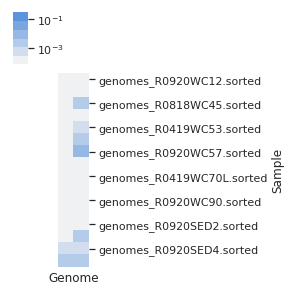

In [222]:
#pmo-c phages
subset = ["LacPavin_0920_SED5_scaffold_1734339", "LacPavin_0920_WC57_scaffold_337042"]
sns.clustermap(relpiv_sorted[subset],cmap=new_pal,norm=LogNorm(subcov["relative_coverage"].min(), subcov["relative_coverage"].max()), 
    row_cluster=False, col_cluster=False, xticklabels=False, figsize=(4,4), dendrogram_ratio=(0.1,0.2))
plt.savefig(rootdir + "figures/phage_subset_heatmap.svg", format="svg")
plt.show()

In [ ]:
genome_rel_cov = pd.read_csv("/groups/banfield/projects/environmental/LacPavin/analysis/tables/genome_rel_cov.tsv", sep="\t")
gpiv = genome_rel_cov.pivot("Sample", "genome_name", "relative_coverage").reset_index().fillna(subcov["relative_coverage"].min()*1.01)
grc_sorted = gpiv.sort_values(by="Sample", key=lambda col: [x.split(".")[0].split("_R")[1][5:] for x in col])
grc_sorted.index = grc_sorted["Sample"]
grc_sorted = grc_sorted.drop("Sample", axis=1)

subset = ["LacPavin_0818_WC45_Methylococcales_40_20", "LacPavin_0818_WC40_Methylococcales_40_12"]
sns.clustermap(grc_sorted[subset],cmap=new_pal,norm=LogNorm(subcov["relative_coverage"].min(), subcov["relative_coverage"].max()), 
    row_cluster=False, col_cluster=False, xticklabels=False, figsize=(4,4), dendrogram_ratio=(0.1,0.2))
plt.savefig(rootdir + "figures/methyl_heatmap.svg", format="svg")
plt.show()